# NYT Topic Modelling

In this notebook, I extract New York Times data and analyse the most important words, relevant topics and clusters for each news desk. 

In [1]:
! pip install pyjq # library for NYT API data extraction

In [2]:
# importing
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np
import warnings
import random
import operator
import os
import re
import multiprocessing
from collections import defaultdict

import requests
import datetime
import time
from dateutil.rrule import rrule, MONTHLY
import pyjq

import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()

from gensim.models import Doc2Vec, LdaMulticore, TfidfModel, CoherenceModel
from gensim.models.doc2vec import FAST_VERSION
from gensim.models.doc2vec import TaggedDocument
from gensim.corpora import Dictionary

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D
import seaborn 

In [3]:
random_state = 42
key = 'YOUR API KEY' # API key from NYT developers (link below)

## 1. Data and Preprocessing

In [4]:
startdate = datetime.date(2019,10,1) # set start date
enddate = datetime.date(2020,2,29) # set end date
dates = [(dt.year, dt.month) for dt in rrule(MONTHLY, dtstart = startdate, until= enddate)]
A = dates[:round(len(dates) / 2)]
B = dates[round(len(dates) / 2):]
print(A,B)

[(2019, 10), (2019, 11)] [(2019, 12), (2020, 1), (2020, 2)]


In [5]:
def extraction(dates):
    """
    Function for extracting relevant data from NYT
    """
    output = []
    for year, month in dates:
        print(year,month)
        time.sleep(10)
        url = f'https://api.nytimes.com/svc/archive/v1/{year}/{month}.json?api-key={key}'
        r = requests.get(url)
        json_data = r.json()
        jq_query = f'.response .docs[] | {{the_headline: .headline .main, the_snippet: .snippet ,the_date: .pub_date, the_news_desk: .news_desk}}' # specify query
        data = pyjq.all(jq_query, json_data)

        output.append(json_normalize(data)) # append dataframe to list
    return output

In [6]:
output_1 = extraction(A)
output_2 = extraction(B)
output1 = []
output2 = []
for i in range(1,len(A)):
    output1 = output_1[0].append(output_1[i])
for i in range(1,len(B)):
    output2 = output_2[0].append(output_2[i])
    
df = pd.concat([output1,output2])
#df.to_csv('nyt_data.csv', index = False) uncomment to write new data set.
print(df.shape)

2019 10
2019 11
2019 12
2020 1
2020 2
(26451, 4)


### Preprocessing:
   - Removing "meaningless" articles (wordquizzes, corrections) as there is nothing to be learned here
   - Focusing on the 10 most frequent news desks. This is the core of my analysis so I want representative new desks
   - Entity recognition. Reason: Recognise "New York" for example to reduce variation in the dataset
   - Remove unnecssary "’s" (spacy tokenises those): Reason: Tokenised by spacy. No information here
   - Remove stop words. Reason: No information here to be learned
   - Remove punctuation. Reason: No information here to be learned

Note: the preprocessing function allows to use POS tagging to run pre-processing. I tried both and cannot recommend that option. 

In [7]:
data = pd.read_csv('nyt_data.csv') # for consistency with later analysis
data['the_date'] = pd.to_datetime(data['the_date'])
data.dropna(inplace = True) # Dropping all NA's
print(f'The data has {len(data)} documents, with the columns:\n{data.columns} \nThe columns have the following type:\n{data.dtypes}')

The data has 25981 documents, with the columns:
Index(['the_headline', 'the_snippet', 'the_date', 'the_news_desk'], dtype='object') 
The columns have the following type:
the_headline                  object
the_snippet                   object
the_date         datetime64[ns, UTC]
the_news_desk                 object
dtype: object


In [8]:
# Cleaning out "meaningless" articles such as wordquizzes
data.drop(data[data['the_headline'].str.contains("Word + Quiz", regex = False)].index, inplace=True)
# Cleaning out "meaningless" articles such as corrections
data.drop(data[data['the_snippet'].str.contains("Corrections that appeared in print on", regex = False)].index, inplace = True)
# Cleaning out picture promts (https://www.nytimes.com/column/learning-picture-prompt)
data.drop(data[data['the_snippet'].str.contains("What do you think this image is saying", regex = False)].index, inplace = True)

# Picking out the top 10 news desks by frequency
top_10_news_desks = data.the_news_desk.value_counts()[0:10].index
# Filtering out accordingly
data = data[data.the_news_desk.apply(lambda x: x in top_10_news_desks)]
# Combining the headline + the snippet. This gives more information about the underlying document. 
data['text'] = data['the_headline'] + ". " + data['the_snippet']
#data['text'] = data['the_snippet']
data = data.loc[:,['text', 'the_date', 'the_news_desk']]

In [9]:
def preprossessing(sentence, entity_rec = False, POS_tagging_prep = True):
    """
    Input: A document
    Output: A cleaned, tokenised document
    """
    s_list = []
    # POS_tagging and preprocessing 
    if POS_tagging_prep == True:
        s_analysed = nlp(sentence)
        for token in s_analysed:
            if token.pos_ in ['PROPN', 'NOUN', 'VERB', 'NUM', 'ADJ', 'INTJ'] and (token.lemma_.lower() != '’s'):
                s_list.append(token.lemma_.lower())
    # Tokenisation / stop-word removal / punctuation removal / url removal
    else:
        spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
        if entity_rec == True:
            s_analysed = nlp(sentence)
            # Entity recognition
            entity = [entity.text for entity in s_analysed.ents]
            for words in entity:
                modified_words = words.replace(" ", "_")
                sentence = sentence.replace(words, modified_words)        
        s_analysed = nlp(sentence.replace("’s", "")) # removal of ’s before tokenisation 
        for token in s_analysed:
            if (token.is_stop is False) and (token.is_punct is False) and (token.like_url is False):
                s_list.append(token.lemma_.lower())
    return s_list 

In [10]:
# Run preprocessing function on data 
data_processed = data.copy()
data_processed.text = data_processed.text.apply(preprossessing, entity_rec = True, POS_tagging_prep = False)
# Resetting index
data_processed.reset_index(inplace = True)        

In [11]:
# Statistics:
print(f'Number of documents after preprossessing: {len(data_processed.text)}')
print(f'Number of tokens after preprossessing: {sum([len(lister) for lister in data_processed.text])}')
print(f'Average number of tokens per document: {round(sum([len(lister) for lister in data_processed.text]) / len(data_processed.text),1)}')

Number of documents after preprossessing: 14549
Number of tokens after preprossessing: 236366
Average number of tokens per document: 16.2


### Research question: 
Bias in reporting is a hot topic at the moment. In this sense, I am interested in understanding what the New York Times has reported upon over the last couple of months. In particular, I am interested in the NYT's reporting from a linguistic, topics and political perspective. My focus lies on the different news desks within the New York Times.

In detail, I will work through the following questions:
- How similar are the news desks from a linguistic perspective? 
- What are the important terms per news desk?
- What topics are covered?
- What is the "political orientation" of the news desks?

Please further note that I have included the visualizations in the analysis part.

### 1. Document Embeddings

In [12]:
# Dense embeddings: 
corpus = []
label = 0
for row in data_processed.iterrows():
    text = row[1].text
    corpus.append(TaggedDocument(text, tags=[str(label)]))
    label +=1
    
# Doc2Vec Model
d2v_model = Doc2Vec(vector_size=100,
                    window=5,
                    hs=0,
                    sample=0.0001,
                    negative=5,
                    min_count=10,
                    workers=-1,
                    epochs=500,
                    dm=0, 
                    dbow_words=1)

d2v_model.build_vocab(corpus, update=False)
d2v_model.train(corpus, total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)

#### Exploring latent dimensions of Doc2Vec embeddings | T-SNE & SVD

In [13]:
assert len(d2v_model.docvecs.vectors_docs) == len(data_processed)

In [14]:
sample_size = 0.1 # taking a representative sample from the data
vectors = pd.DataFrame(d2v_model.docvecs.vectors_docs)
vectors_sample = vectors.sample(int(round(sample_size*len(vectors),0)))
news_desks_labels = pd.DataFrame(data_processed.the_news_desk[vectors_sample.index])
assert sum(vectors_sample[0].index != news_desks_labels.index) == 0

In [15]:
news_desks_labels.reset_index(drop = True, inplace = True)

In [16]:
tsne_d2v = TSNE(n_components=2, verbose = 1, random_state = random_state).fit_transform(vectors_sample)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1455 samples in 0.007s...
[t-SNE] Computed neighbors for 1455 samples in 0.375s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1455
[t-SNE] Computed conditional probabilities for sample 1455 / 1455
[t-SNE] Mean sigma: 0.007519
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.132957
[t-SNE] KL divergence after 1000 iterations: 3.078355


In [17]:
tsne_d2v_df = pd.DataFrame(data=tsne_d2v, columns=["x", "y"])
tsne_d2v_df['label'] = news_desks_labels

In [18]:
svd = TruncatedSVD(n_components=2)
low_dim_svd = TruncatedSVD(n_components=2)
low_dim_U = low_dim_svd.fit_transform(vectors_sample)
assert len(low_dim_U) == len(news_desks_labels)
svd_data = pd.DataFrame(low_dim_U, columns = ['x','y'])
svd_data['label'] = news_desks_labels

Text(0.5, 1.0, 'T-SNE Decomposition')

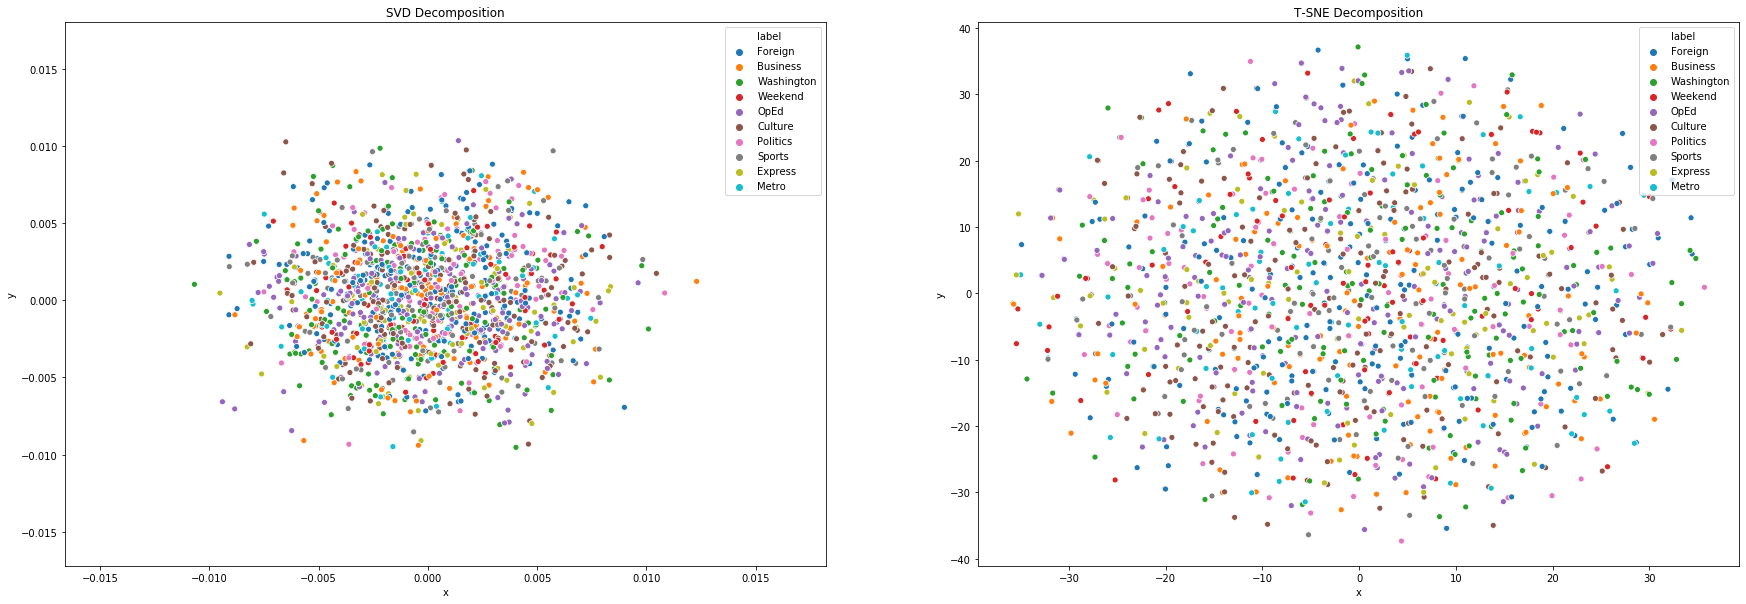

In [19]:
plt.figure(figsize = (30, 10))
ax = plt.subplot(1,2,1)
seaborn.scatterplot('x', 'y', data=svd_data, hue='label', ax=ax)
ax.set_title('SVD Decomposition')
ax = plt.subplot(1,2,2)
seaborn.scatterplot('x', 'y', data=tsne_d2v_df, hue='label',ax=ax)
ax.set_title('T-SNE Decomposition')

#### Visualization of Doc2Vec embeddings - TSNE embeddings in more detail 

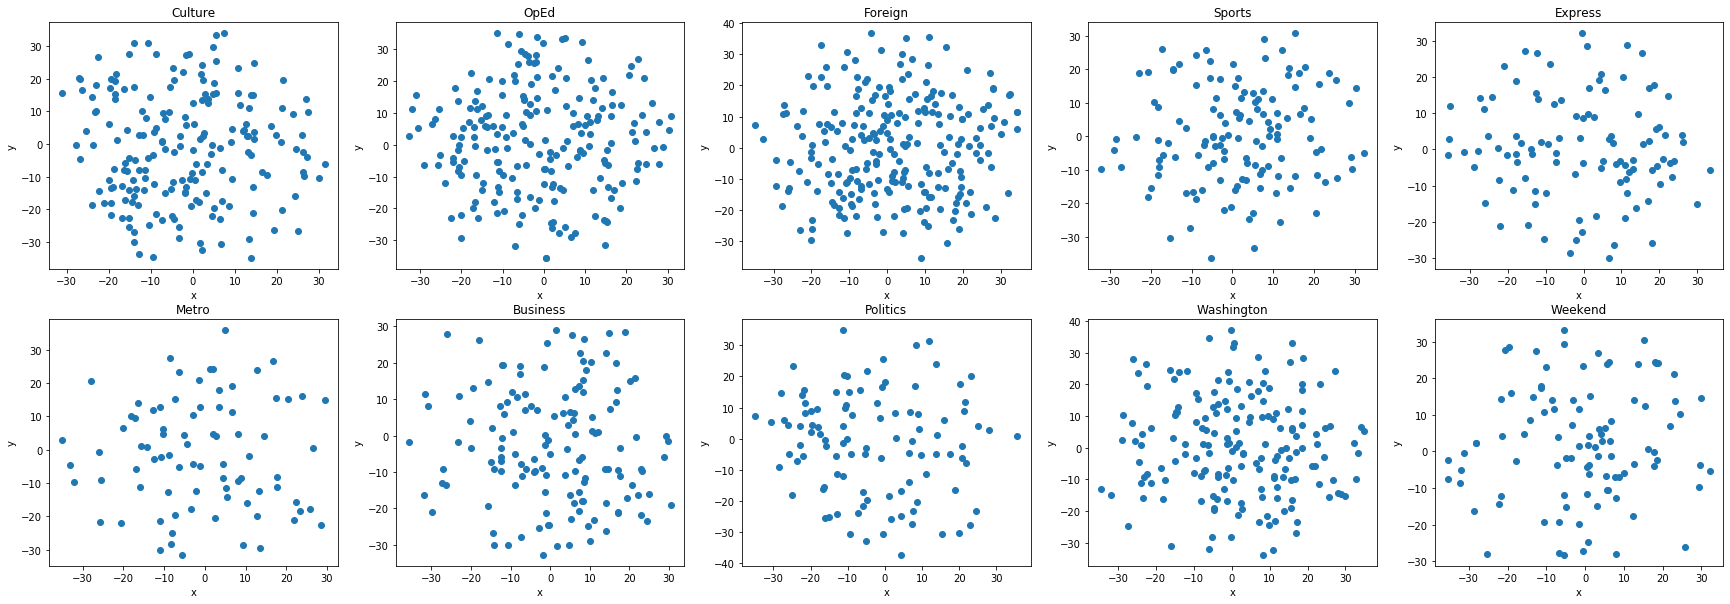

In [20]:
iterator = 0
position = np.arange(10)
position = position.reshape((2, 5))

fig, axs = plt.subplots(nrows=2, ncols=5, facecolor='w', figsize=(30,10))
for i in data_processed.the_news_desk.unique():
    (x,y) = np.where(position == iterator)
    ax = axs[int(x), int(y)]
    df = tsne_d2v_df[tsne_d2v_df.label == i]
    
    ax.scatter(df.x, df.y)
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(i)
    iterator += 1

Despite taking a small sample in order to visualize better, we can see that there is no pattern between the different news desks in terms of document embeddings. If we consider document embeddings as the linguistic profile of a document, we shouldn't be surprised of this result. The linguistic profile seems to be similiar in each news desk. 

### 2. Analysis of important terms per news desk

In [21]:
most_important_terms_per_news_desk = {k : [] for k in data_processed.the_news_desk.unique()} # setting up a dictionary to store

for news_desk in data_processed.the_news_desk.unique():
    data_news = data_processed[data_processed.the_news_desk == news_desk]
    core_sentences = [" ".join(i) for i in data_news.text]
    
    tfidf_vectorizer = TfidfVectorizer(analyzer='word', min_df=0.001, max_df=0.8, stop_words='english', sublinear_tf=True)
    vectorizer = CountVectorizer(analyzer='word', min_df=0.001, max_df=0.8, stop_words='english')
    X = tfidf_vectorizer.fit_transform(core_sentences)
    X2 = vectorizer.fit_transform(core_sentences)

    df = pd.DataFrame(data={'word': vectorizer.get_feature_names(), 
                            'tf': X2.sum(axis=0).A1, 
                            'idf': tfidf_vectorizer.idf_,
                            'tfidf': X.sum(axis=0).A1
                           })
    df = df.sort_values(['tfidf', 'tf', 'idf'])
    #print(f'{news_desk}:{df.tail(3)}')
    most_important_terms_per_news_desk[news_desk].append(df)

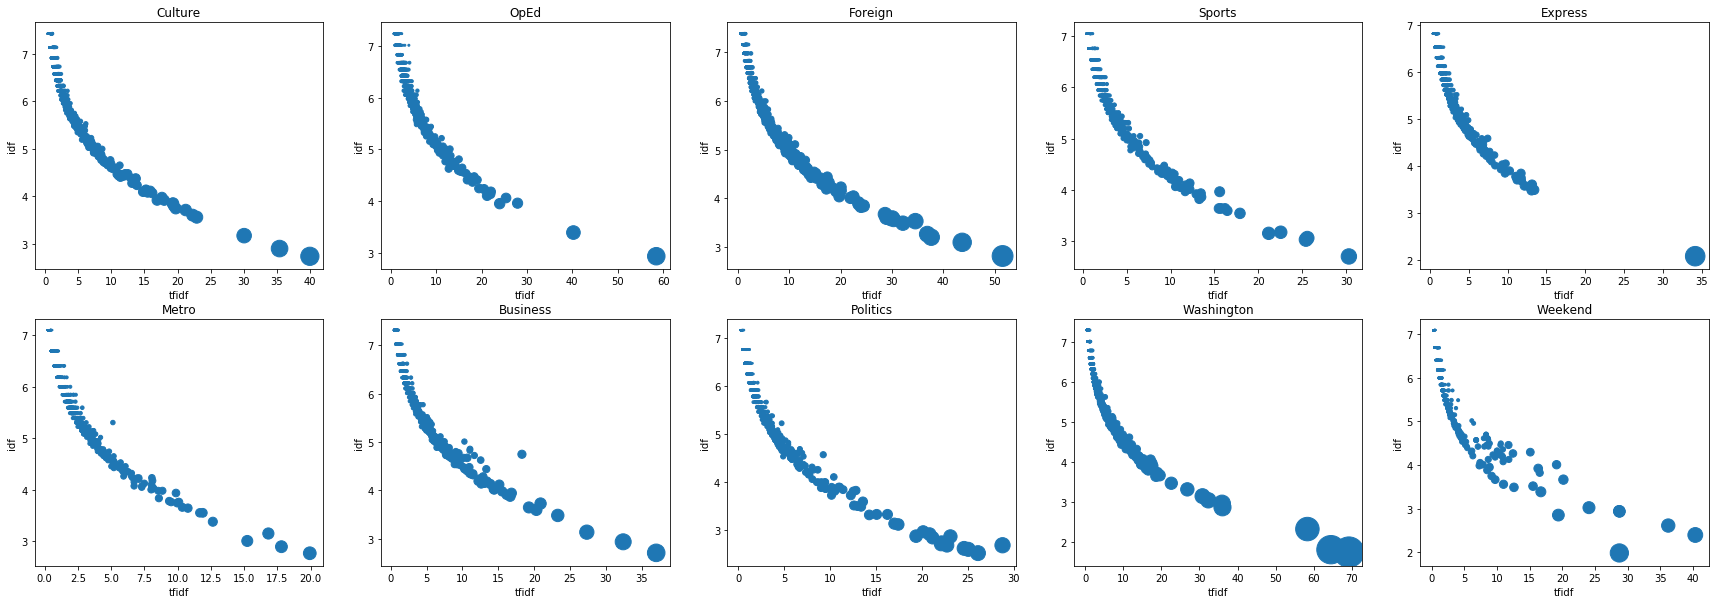

In [22]:
iterator = 0
position = np.arange(10)
position = position.reshape((2, 5))

fig, axs = plt.subplots(nrows=2, ncols=5, facecolor='w', figsize=(30,10))
for k,v in most_important_terms_per_news_desk.items():
    df = v[0]
    (x,y) = np.where(position == iterator)
    ax = axs[int(x), int(y)]
    ax.scatter(df.tfidf, df.idf, s = df.tf)
    ax.set_title(k)
    ax.set_xlabel('tfidf')
    ax.set_ylabel('idf')
    iterator += 1

#### Zoom into the most important terms per desk (top 5)

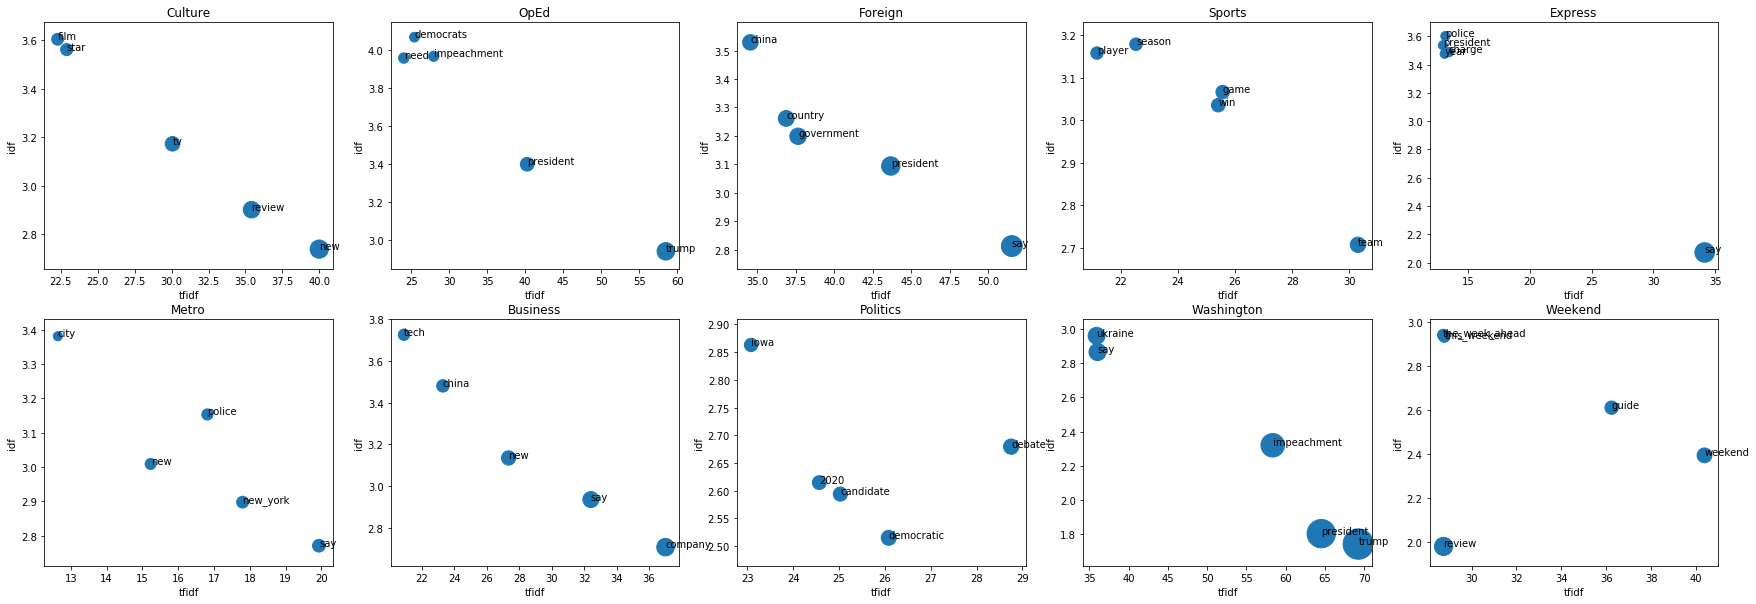

In [23]:
iterator = 0
position = np.arange(10)
position = position.reshape((2, 5))

fig, axs = plt.subplots(nrows=2, ncols=5, facecolor='w', figsize=(30,10))
for k,v in most_important_terms_per_news_desk.items():
    coordinates = []
    df = v[0].tail()
    df.reset_index(inplace = True)
    coordinates = [(df.word[i], df.tfidf[i], df.idf[i]) for i in range(len(df))]
    (x,y) = np.where(position == iterator)
    ax = axs[int(x), int(y)]
    ax.scatter(df.tfidf, df.idf, s = df.tf)
    ax.set_title(k)
    ax.set_xlabel('tfidf')
    ax.set_ylabel('idf')
    for i, txt in enumerate(df.word):
        ax.annotate(txt, (df.tfidf[i], df.idf[i]))
    iterator += 1

#### Even more visualisations

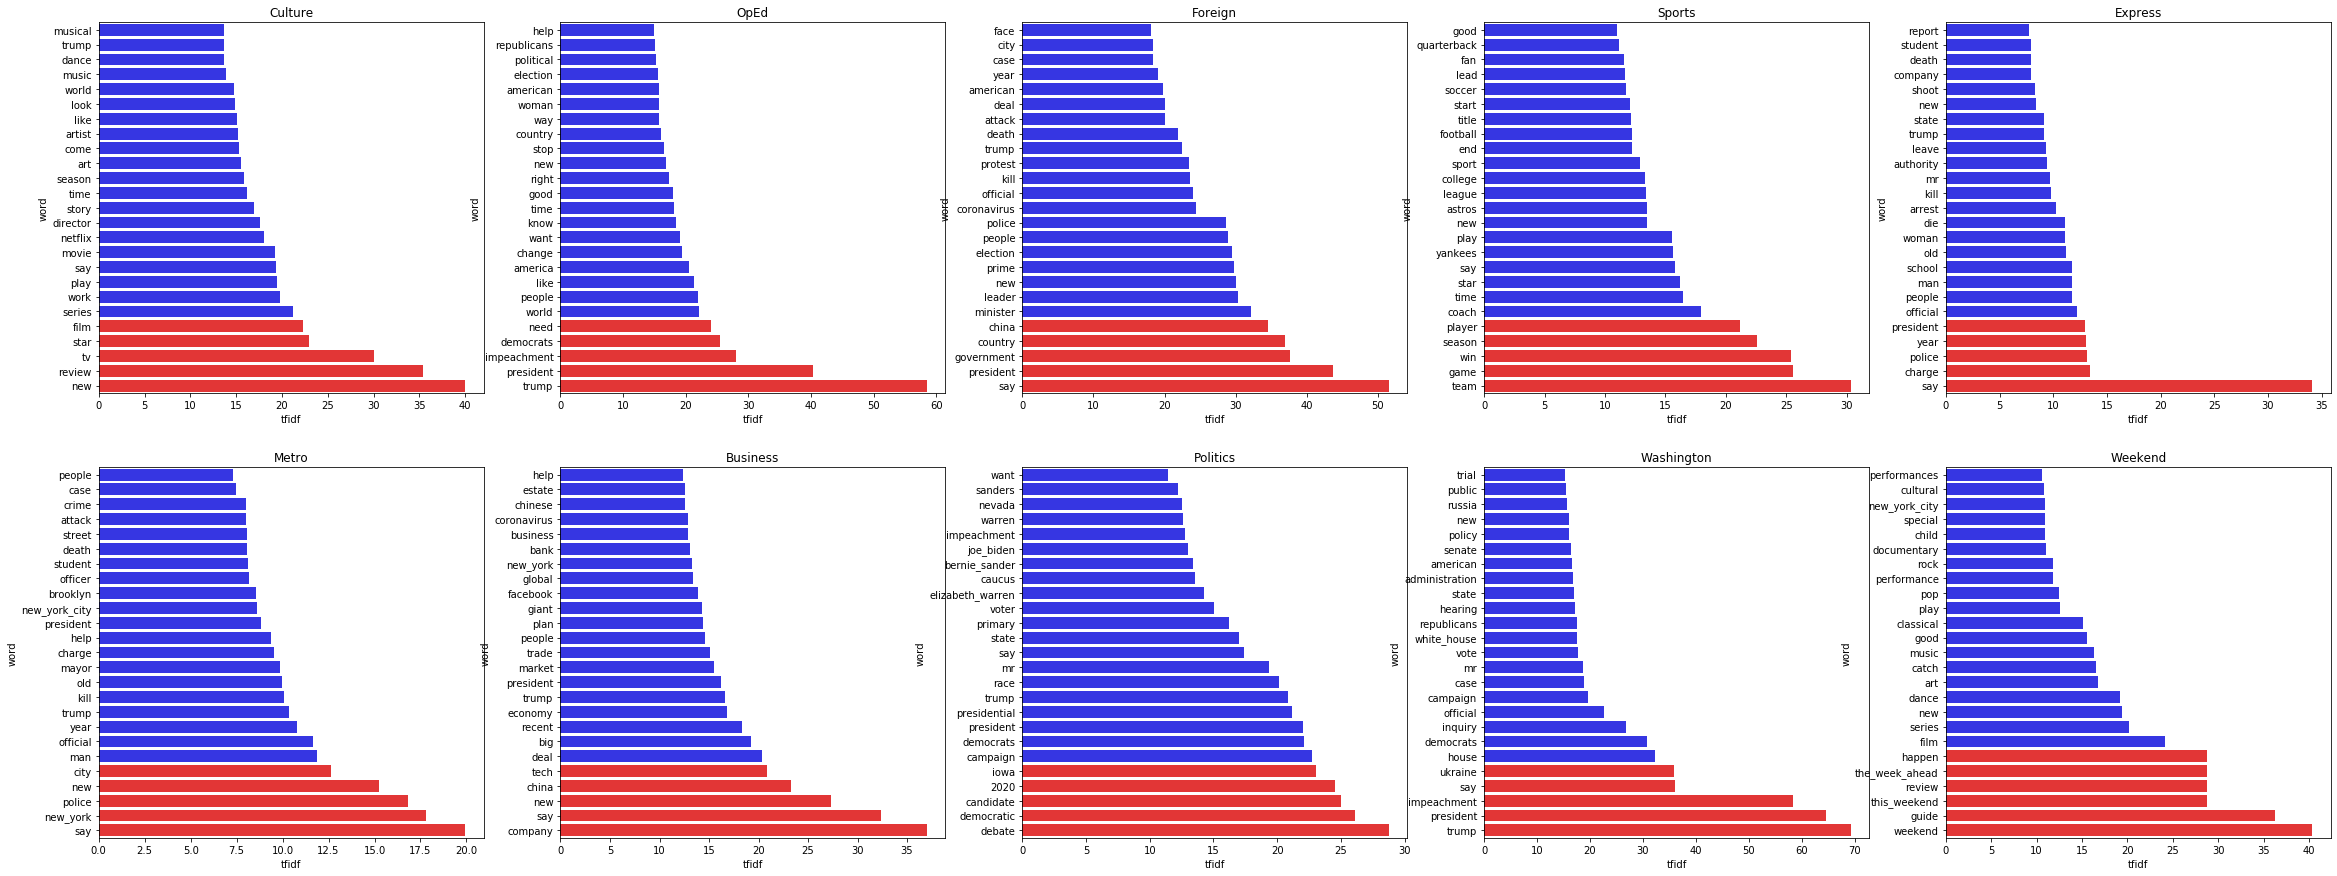

In [24]:
iterator = 0
position = np.arange(10)
position = position.reshape((2, 5))

fig, axs = plt.subplots(nrows=2, ncols=5, facecolor='w', figsize=(40,15))
for k,v in most_important_terms_per_news_desk.items():
    (r,c) = np.where(position == iterator)    
    df= v[0].tail(25)
    clrs = ['blue' if (x < sorted(df.tfidf)[-5]) else 'red' for x in df.tfidf]
    seaborn.barplot(df.tfidf, df.word, alpha=0.9,ax = axs[int(r)][int(c)], palette=clrs)
    axs[int(r)][int(c)].set_title(k)
    iterator += 1

In red, you see the words that were plotted in the visualisation before. In blue, you can see the other top words for each catagory. Most news desks are identifiable by the most important words they publish:
- **Culture:** clearly focuses on art, music and film (film, star, tv, movie, art)
- **OpEd:** demonstrates the political orientation of the NYT (impeachment, president, trump). This seems to be a first hint with regards to the polticial bias.
- **Foreign:** focuses on foreign policy and politics (china, country, president)
- **Sports:** focus on American sports (team, coach, yankees, football...)
- **Express:** no clear focus
- **Metro:** local on New York (NYC, New York, brookyln, city)
- **Business:** interested in what's hot in the business world? Seems to be something around tech, China and Facebook
- **Politics:** focus on the 2020 democratic election campaign (debate, iowa, democratic, candidate). Another sign of the political orientation, can be found here. 
- **Washington:** focused on politics (impeachment, white_house, trump). Evidence for political bias.
- **Weekend:** local focus on what's going on in NYC over the weekend (guide, weekend, art, dance)

Sidenote: The entity recognition in the pre-processing seems key. A lot of entities are important!

### 3. Topic modeling 

### LDA

In [25]:
# Setting seed:
random.seed(random_state)
dictionary = Dictionary(data_processed.text)
dictionary.filter_extremes(no_below=30, no_above=0.5)
print(dictionary)

Dictionary(1393 unique tokens: ['man', 'netflix', 'new', 'premiere', 'series']...)


In [26]:
ldacorpus = [dictionary.doc2bow(text) for text in data_processed.text]
# learn TFIDF values from corpus
print("tf-idf transformation", flush=True)
tfidfmodel = TfidfModel(ldacorpus)
model_corpus = tfidfmodel[ldacorpus]

tf-idf transformation


#### Choosing number of topics

In [27]:
coherence_values = []
model_list = []

dev_size = 5000
eval_size = 1000

random.seed(random_state)
for num_topics in range(4, 10):
    model = LdaMulticore(corpus=model_corpus[:dev_size], 
                         id2word=dictionary, 
                         workers=min(10, multiprocessing.cpu_count()-1),
                         num_topics=num_topics)

    coherencemodel_umass = CoherenceModel(model=model, 
                                          texts=data_processed.text[dev_size:dev_size+eval_size], 
                                          dictionary=dictionary, 
                                          coherence='u_mass')

    umass_score = coherencemodel_umass.get_coherence()
    coherence_values.append((num_topics, umass_score))
    
scores = pd.DataFrame(coherence_values, columns=['num_topics', 'UMass'])

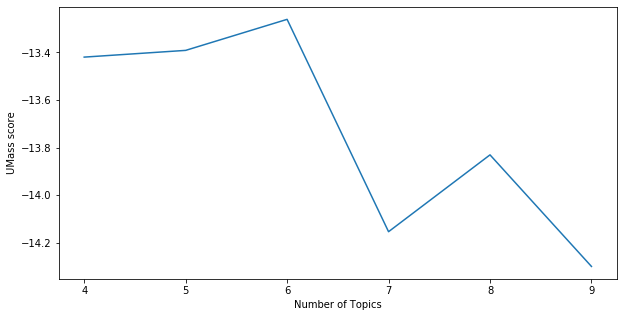

In [28]:
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(scores.num_topics, scores.UMass)
plt.xlabel('Number of Topics')
plt.ylabel('UMass score')
plt.show()

Reason for picking 6 topics: best UMass score

In [50]:
num_topics = 6
# find chunksize to make about 200 updates
num_passes = 3
chunk_size = len(model_corpus) * num_passes/200

In [51]:
model = LdaMulticore(num_topics=num_topics, # number of topics
                     corpus=model_corpus, # what to train on 
                     id2word=dictionary, # mapping from IDs to words
                     workers=min(10, multiprocessing.cpu_count()-1), # choose 10 cores, or whatever computer has
                     passes=num_passes, # make this many passes over data
                     chunksize=chunk_size, # update after this many instances
                     alpha=0.5) # tune alpha

In [52]:
topic_corpus = model[model_corpus]
# get the topic descritions
topic_sep = re.compile(r"0\.[0-9]{3}\*") # getting rid of useless formatting
# extract a list of tuples with topic number and descriptors from the model
model_topics = [(topic_no, re.sub(topic_sep, '', model_topic).split(' + ')) for topic_no, model_topic in
                model.print_topics(num_topics=num_topics, num_words=5)]

descriptors = []
for i, m in model_topics:
    print(i+1, ", ".join(m[:5]))
    descriptors.append(", ".join(m[:2]).replace('"', ''))

1 "win", "season", "team", "star", "not"
2 "president", "trump", "impeachment", "democrats", "2020"
3 "coronavirus", "country", "people", "lose", "government"
4 "review", "happen", "weekend", "guide", "show"
5 "say", "case", "iowa", "leader", "court"
6 "new", "tv", "movie", "series", "time"


#### Aggregating to news desk

In [53]:
target_category = 'the_news_desk'
# get a list of all the topic scores for each document
scores = [[t[1] for t in topic_corpus[entry]] for entry in range(len(model_corpus))]
# turn that into a data frame with N rows and K columns, each with the score of the corresponding topic
topic_distros = pd.DataFrame(data=scores, columns=descriptors)
# add the review category of each document (so we can aggregate)
topic_distros['category'] = data_processed[target_category]

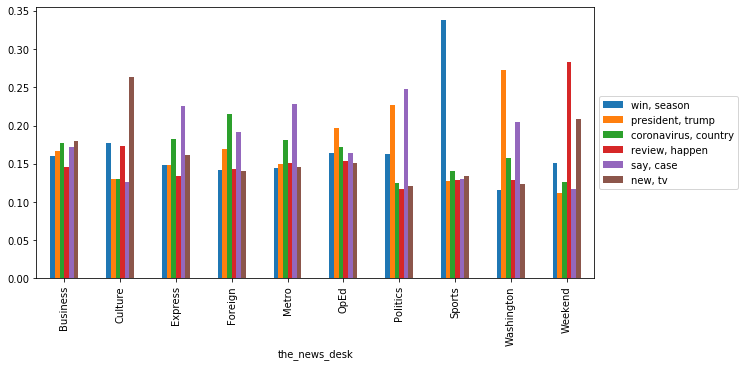

In [54]:
fig, ax = plt.subplots(figsize=(10, 5)) # set graph size
# aggregate topics by categories
aggregate_by_category = topic_distros.groupby(data_processed.the_news_desk).mean()
# plot the graph
aggregate_by_category[descriptors].plot.bar(ax=ax);
# move the legend out
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));

### Matrix Factorisation TF-IDF embeddings

#### Exploring latent dimensions of TF-IDF embeddings | SVD & NMF

In [55]:
x_words = most_important_terms_per_news_desk['Culture'][0].word
x = most_important_terms_per_news_desk['Culture'][0].drop(['word'], axis = 1)

In [56]:
core_sentences = [" ".join(i) for i in data_processed.text]
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), 
                                   stop_words='english', 
                                   analyzer='word', 
                                   min_df=0.001, 
                                   max_df=0.7, 
                                   sublinear_tf=True, 
                                   use_idf=True)

tfidf_df_entire_corpra = tfidf_vectorizer.fit_transform(core_sentences)

In [57]:
k = num_topics # number of latent dimensions
svd = TruncatedSVD(n_components=k)
U = svd.fit_transform(tfidf_df_entire_corpra)
S = svd.singular_values_
V = svd.components_
assert U.shape[0] == len(core_sentences)

In [58]:
def show_topics(A, vocabulary, topn=5):
    """
    find the top N words for each of the latent dimensions (=rows) in a
    """
    topic_words = ([[vocabulary[i] for i in np.argsort(t)[:-topn-1:-1]]
                    for t in A])
    return [', '.join(t) for t in topic_words]

In [59]:
terms = tfidf_vectorizer.get_feature_names()
sorted(show_topics(V, terms))

['debate, candidate, democratic, democrats, 2020',
 'impeachment, year, old, say, year old',
 'say, happen, guide, weekend guide, weekend',
 'trump, president, president trump, impeachment, ukraine',
 'trump, president, say, president trump, impeachment',
 'weekend, guide, weekend guide, happen, review']

In [60]:
nmf = NMF(n_components=k, init=None, random_state=random_state)
W = nmf.fit_transform(tfidf_df_entire_corpra)
H = nmf.components_
sorted(show_topics(H, terms))

['debate, democratic, candidate, democrats, 2020',
 'review, new, star, film, play',
 'say, china, government, company, country',
 'trump, president, president trump, impeachment, ukraine',
 'weekend, guide, weekend guide, happen, this_weekend',
 'year, old, year old, police, man']

#### Visualizing latent dimensions

In [61]:
sample_size = 0.1 # taking a representative sample from the data
sentences = pd.DataFrame(core_sentences)
sentences_sample = vectors.sample(int(round(sample_size*len(sentences),0)))
news_desks_labels = pd.DataFrame(data_processed.the_news_desk[sentences_sample.index])
assert sum(sentences_sample[0].index != news_desks_labels.index) == 0

In [62]:
news_desks_labels.reset_index(drop = True, inplace = True)

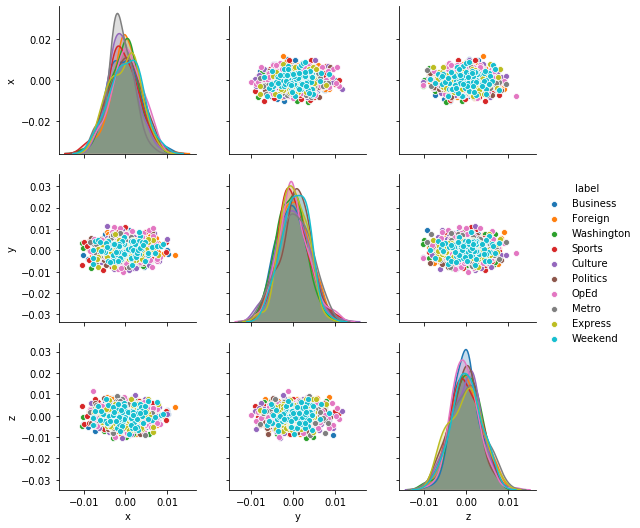

In [63]:
low_dim_svd = TruncatedSVD(n_components=3)
low_dim_U = low_dim_svd.fit_transform(sentences_sample)
assert len(low_dim_U) == len(sentences_sample)
svd_data = pd.DataFrame(low_dim_U, columns = ['x','y', 'z'])
svd_data['label'] = news_desks_labels
seaborn.pairplot(svd_data, hue='label', diag_kind="kde")

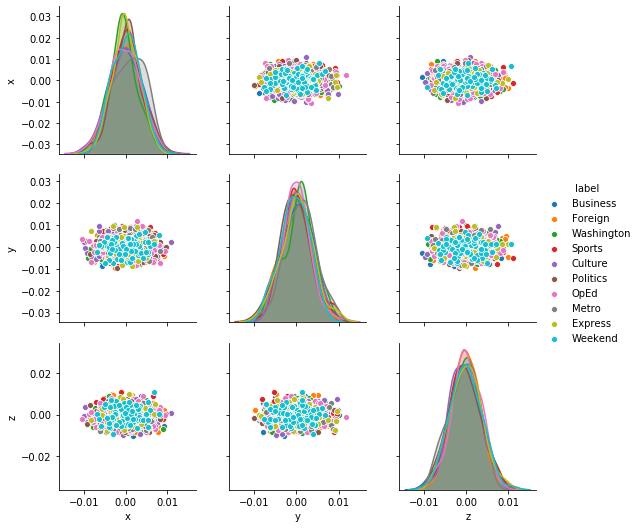

In [64]:
low_dim_nmf = NMF(n_components=3,init=None, random_state=random_state)
low_dim_W= low_dim_svd.fit_transform(sentences_sample)
assert len(low_dim_W) == len(sentences_sample)
nmf_data = pd.DataFrame(low_dim_W, columns = ['x','y', 'z'])
nmf_data['label'] = news_desks_labels
seaborn.pairplot(nmf_data, hue='label')

When I compare the matrix factorization to the LDA topic model, there are three observations to be made:
- First, the optimal number of topics discovered by the UMass score differes from the news desks. I think this is makes sense as there is quite a lot of overlap between the different news desks as seen by the important terms. The clustering analysis will show similar results.
- Second, comparing the topic descriptors in the LDA model to the result in the SVD & NMF factorization (V & H), we see similarities. There seems to be a stable topic around Donald Trump and the impeachment process and the democratic debate. This is another piece of evidence of the political orientation of the NYT.
- Third, looking at the pair plots for the SVD and NMF decompositions (U & W), there is no clear differentiable document representation in lower dimensions between the news desks. This observation is similar to the one I made on the Doc2Vec embeddings. I argue that this makes sense. Lower dimensional representations relate to "things like societal norms, communicative goals, larger topics, discourse coherence, and many more" (Text processing with Python for social scientists, Dirk Hovy, page: 54). I exepct that this is more or less the same over all documents written at the NYT. 

Overall, it becomes clear that the representation of words - in the topic model as well as in the representation of words in lower dimensions by matrix representation - is more fruitful than the analysis of document embeddings.

## 4. Clustering

In [65]:
tfidf_df_entire_corpra_SVD_300 = TruncatedSVD(n_components=300).fit_transform(tfidf_df_entire_corpra)
assert len(tfidf_df_entire_corpra_SVD_300) == len(data_processed)
sample = np.random.choice(len(tfidf_df_entire_corpra_SVD_300), replace=False, size=5000)

In [66]:
silhouettes = []
K = range(4, 20)
for k in K:
    agg_clustering = AgglomerativeClustering(n_clusters=k)
    agg_cluster_ids = agg_clustering.fit_predict(tfidf_df_entire_corpra_SVD_300[sample])
    score = silhouette_score(tfidf_df_entire_corpra_SVD_300[sample], agg_cluster_ids)
    silhouettes.append(score)

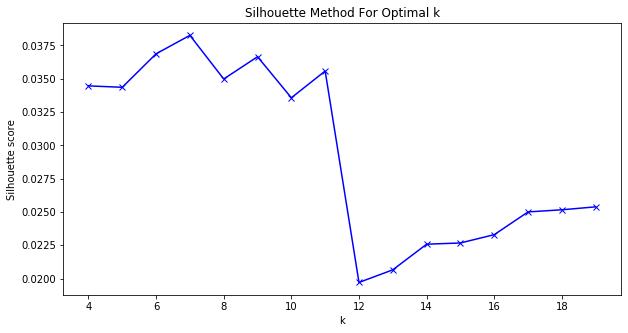

In [68]:
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(K, silhouettes, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Silhouette Method For Optimal k')
plt.show()

In [74]:
k = pd.Series(silhouettes).idxmax() + K[0] # final number of clusters suggested by the silhouette method
agg = AgglomerativeClustering(n_clusters=k)
agg_ids = agg.fit_predict(tfidf_df_entire_corpra_SVD_300)
centroids = np.array([tfidf_df_entire_corpra_SVD_300[agg_ids == c].mean(axis=0) for c in range(k)])

km = KMeans(n_clusters=k, 
            n_jobs=-1, 
            init=centroids)

km.fit(tfidf_df_entire_corpra_SVD_300)

KMeans(algorithm='auto', copy_x=True,
       init=array([[ 7.43274238e-02, -4.32697814e-02, -1.94717461e-03, ...,
         5.60487471e-05,  3.15583497e-04,  8.92757134e-05],
       [ 3.26955058e-02, -7.79343280e-02,  4.66616280e-01, ...,
        -1.59443628e-03,  2.43169108e-03,  2.88473563e-03],
       [ 1.83687772e-01,  1.01829997e-01,  1.53432761e-02, ...,
         2.04896570e-04,  1.29363638e-04,  1.90414651e-03],
       ...,
       [ 8.204...
         1.32653954e-03, -5.43342290e-04, -5.07311673e-04],
       [ 1.93696235e-02, -2.84966737e-02,  5.86210816e-03, ...,
        -2.05836687e-03,  9.68508107e-04,  4.50709113e-03],
       [ 3.65100097e-02, -1.03320849e-01,  3.49185673e-01, ...,
         1.60325506e-02,  6.29820239e-03, -1.65251511e-02]]),
       max_iter=300, n_clusters=7, n_init=10, n_jobs=-1,
       precompute_distances='auto', random_state=None, tol=0.0001, verbose=0)

Again, it would be interesting to see the clusters for each news desk.
Additionally, to label the clusters, look at the most important words per cluster (top 3) and add label the 

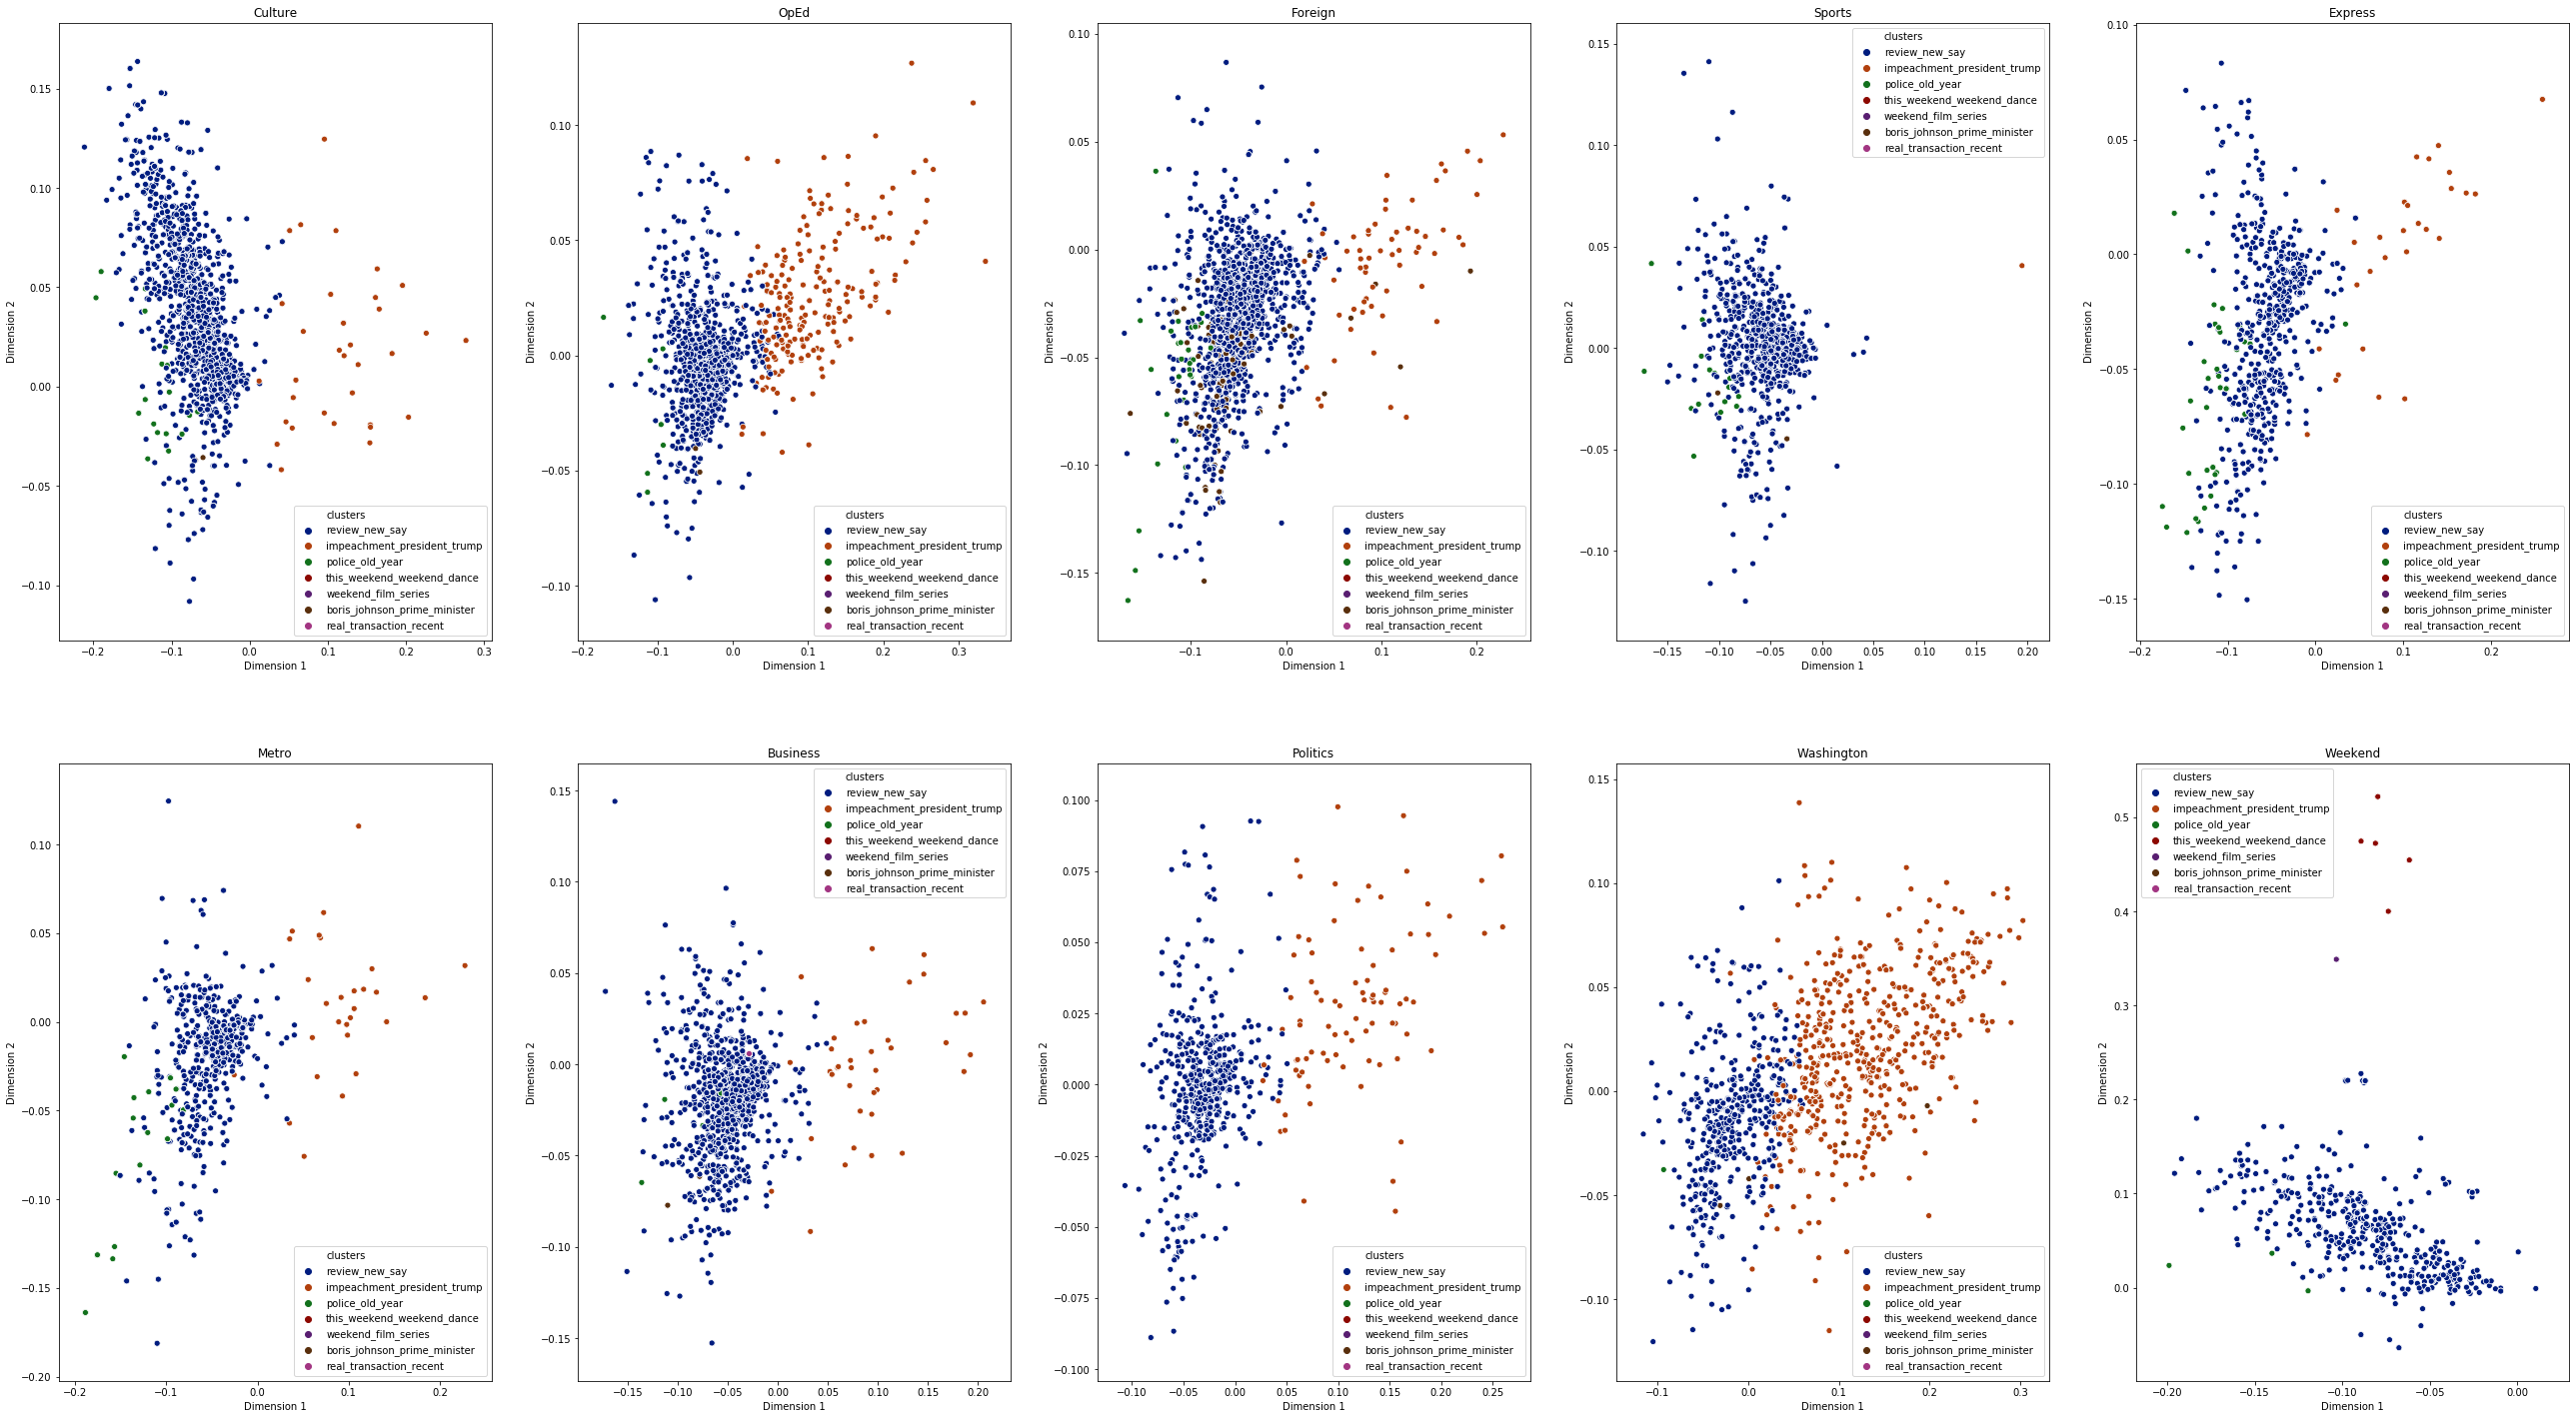

In [75]:
columns = [str("Dimension " + str(i)) for i in range(tfidf_df_entire_corpra_SVD_300.shape[1])]
clustering_data = pd.DataFrame(tfidf_df_entire_corpra_SVD_300, columns = columns)

#clustering_data
clustering_data['clusters'] = km.labels_
clustering_data['news_desk'] = data_processed.the_news_desk

# Generating the most important words per cluster and assigning those as labels
data_processed['clusters'] = km.labels_
most_important_terms_per_cluster = {k : [] for k in data_processed['clusters'].unique()} 

for cluster in data_processed['clusters'].unique():
    data_news = data_processed[data_processed.clusters == cluster]
    core_sentences = [" ".join(i) for i in data_news.text]
    
    tfidf_vectorizer = TfidfVectorizer(analyzer='word',                     
                                       stop_words='english', 
                                       sublinear_tf=True)
    vectorizer = CountVectorizer(analyzer='word', 
                                 stop_words='english')
    X = tfidf_vectorizer.fit_transform(core_sentences)
    X2 = vectorizer.fit_transform(core_sentences)

    df = pd.DataFrame(data={'word': vectorizer.get_feature_names(), 
                            'tf': X2.sum(axis=0).A1, 
                            'idf': tfidf_vectorizer.idf_,
                            'tfidf': X.sum(axis=0).A1
                           })
    df = df.sort_values(['tfidf', 'tf', 'idf'])
    most_important_terms_per_cluster[cluster].append(df)

for k,v in most_important_terms_per_cluster.items():
    clustering_data.loc[clustering_data.clusters == k,['clusters']] = "_".join(v[0].tail(3)['word'].values)

# Plot
iterator = 0
position = np.arange(10)
position = position.reshape((2, 5))
s = seaborn.color_palette('dark', n_colors = len(data_processed['clusters'].unique()))
fig, axs = plt.subplots(nrows=2, ncols=5, facecolor='w', figsize=(45,25))
for i in clustering_data.news_desk.unique():
    (r,c) = np.where(position == iterator) 
    df = clustering_data[clustering_data.news_desk == i]    
    seaborn.scatterplot(x = 'Dimension 1', y= 'Dimension 2', data = df,
                        hue = 'clusters',
                        hue_order = clustering_data.clusters.unique(),
                        ax = axs[int(r)][int(c)],
                        palette = s)
    axs[int(r)][int(c)].set_title(i)
    iterator += 1

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

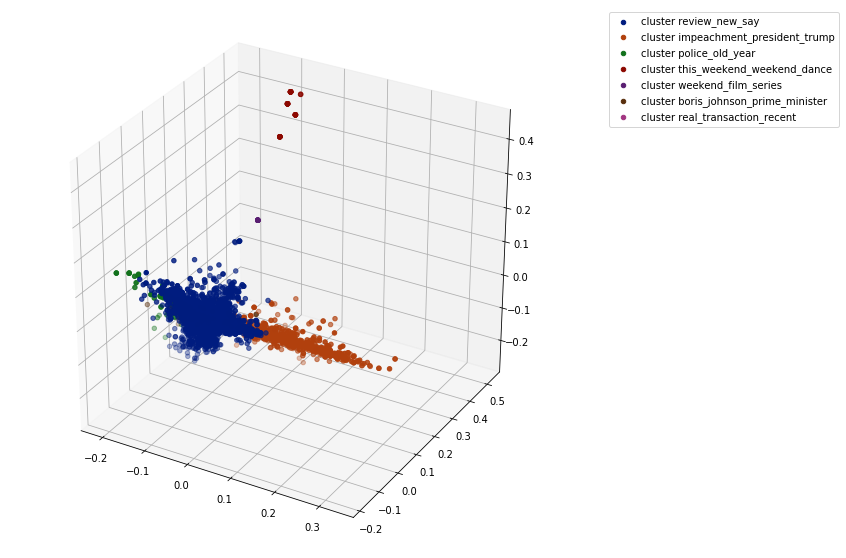

In [78]:
plot_data = clustering_data.sample(n=6000, random_state=random_state).loc[:,['Dimension 1', 
                                                                             'Dimension 2', 
                                                                             'Dimension 3', 
                                                                             'clusters']]
cl = []
for i in range(len(plot_data.clusters.unique())):
    cl.append(plot_data.loc[plot_data.clusters == clustering_data.clusters.unique()[i],:])

colors = [i for i in seaborn.color_palette('dark', n_colors = len(plot_data.clusters.unique()))]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

for i, c in enumerate(cl):
    ax.scatter(c['Dimension 1'],c['Dimension 2'], c['Dimension 3'], c=colors[i], label='cluster {}'.format(clustering_data.clusters.unique()[i]))
ax.legend(bbox_to_anchor = (1.5, 1))
plt.show()


###### A couple of final take-aways:
- Overall, the NYT maintains a **similar style of writing** between the news desks. There are no material differences in the latent dimensions between the news desks. 
- However, looking at the important terms, we see that the **news desks cover different topics**. However, it seems that news desks **overlap in their reporting**.
- LDA and matrix factorisation analysis show that there are **6 "main" topics** that underlie this corpora. Mainly topics around the democratic party, Donald Trump's impeachment process and weekend plans.
- Clustering finds 7 optimal clusterrs. Some of these **clusters are quite distinct**. 
- Last but not least, there is a lot of evidence with regards to the **democratic bias** of the NYT. Cluster "impeachment_president_trump" can be renamed as the **"poltical bias" cluster** and it is mostly present in **OpEd** and **Washington**.  


# References
- https://radimrehurek.com/gensim/auto_examples/tutorials/run_doc2vec_lee.html#sphx-glr-auto-examples-tutorials-run-doc2vec-lee-py
- https://www.kaggle.com/arthurtok/target-visualization-t-sne-and-doc2vec
- https://medium.com/@danalindquist/using-new-york-times-api-and-jq-to-collect-news-data-a5f386c7237b 
- https://developer.nytimes.com